In [1]:
%cd ..
%matplotlib inline

d:\Models\person_attribute_recognition


In [24]:
import math
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from torch.optim import lr_scheduler
from bisect import bisect_right

In [25]:
net = nn.Linear(10, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# CosineAnnealingLR
---
> Cosine Annealing 따라서 learning rate가 서서히 감소하며 최적점을 찾음

c:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:508: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


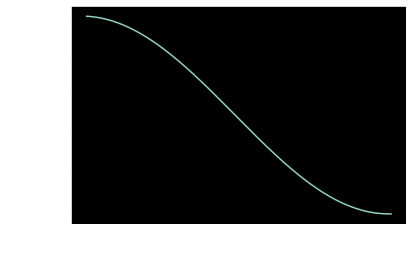

In [26]:
x = []
y = []
cus_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=120, eta_min=0.000001)
for i in range(120):
    cus_lr_scheduler.step()
    for j in range(3):
        x.append(i)
        y.append(cus_lr_scheduler.get_lr()[0])
        optimizer.step()
        
fig = plt.figure()
ax = fig.add_subplot(111)

x = np.array(x)*700
y = np.array(y)

ax.plot(x, y)
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1e'))
ax.set_ylabel('Learning rate')
ax.set_xlabel('Episode')
plt.show()
# plt.close(fig)

# WarmupCosineAnnealingLR
---
> Warmup으로 시작하는 Cosine Annealing learning rate. Cosine Annealing 따라서 증가했다가 감소

In [ ]:
class WarmupCosineAnnealingLR(torch.optim.lr_scheduler._LRScheduler):
    r"""Warpmup learning rate, copied from here: https://github.com/JDAI-CV/fast-reid/blob/master/fastreid/solver/lr_scheduler.py"""

    def __init__(
        self,
        optimizer: torch.optim.Optimizer,
        max_iters: int,
        delay_iters: int = 0,
        eta_min_lr: int = 0,
        warmup_factor: float = 0.001,
        warmup_iters: int = 1000,
        warmup_method: str = "linear",
        last_epoch=-1,
        **kwargs
    ):
        self.max_iters = max_iters
        self.delay_iters = delay_iters
        self.eta_min_lr = eta_min_lr
        self.warmup_factor = warmup_factor
        self.warmup_iters = warmup_iters
        self.warmup_method = warmup_method
        assert (
            self.delay_iters >= self.warmup_iters
        ), "Scheduler delay iters must be larger than warmup iters"
        super(WarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch <= self.warmup_iters:
            warmup_factor = _get_warmup_factor_at_iter(
                self.warmup_method,
                self.last_epoch,
                self.warmup_iters,
                self.warmup_factor,
            )
            return [base_lr * warmup_factor for base_lr in self.base_lrs]
        elif self.last_epoch <= self.delay_iters:
            return self.base_lrs
        elif self.last_epoch <= self.max_iters:
            return [
                self.eta_min_lr
                + (base_lr - self.eta_min_lr)
                * (
                    1
                    + math.cos(
                        math.pi
                        * (self.last_epoch - self.delay_iters)
                        / (self.max_iters - self.delay_iters)
                    )
                )
                / 2
                for base_lr in self.base_lrs
            ]
        else:
            return [self.eta_min_lr for base_lr in self.base_lrs]


def _get_warmup_factor_at_iter(
    method: str, iter: int, warmup_iters: int, warmup_factor: float
) -> float:
    r"""
    Return the learning rate warmup factor at a specific iteration.
    See https://arxiv.org/abs/1706.02677 for more details.
    Args:
        method (str): warmup method; either "constant" or "linear".
        iter (int): iteration at which to calculate the warmup factor.
        warmup_iters (int): the number of warmup iterations.
        warmup_factor (float): the base warmup factor (the meaning changes according
            to the method used).
    Returns:
        float: the effective warmup factor at the given iteration.
    """
    if iter >= warmup_iters:
        return 1.0

    if method == "constant":
        return warmup_factor
    elif method == "linear":
        alpha = iter / warmup_iters
        return warmup_factor * (1 - alpha) + alpha
    else:
        raise ValueError("Unknown warmup method: {}".format(method))

c:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


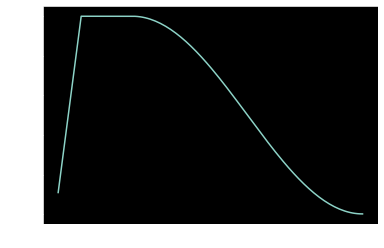

In [15]:
x = []
y = []
cus_lr_scheduler = WarmupCosineAnnealingLR(optimizer, max_iters=120, delay_iters=30, eta_min_lr=0.00001, warmup_factor=0.01, warmup_iters=10, warmup_method="linear")
for i in range(120):
    cus_lr_scheduler.step()
    for j in range(3):
        x.append(i)
        y.append(cus_lr_scheduler.get_lr()[0])
        optimizer.step()
plt.plot(x, y)
plt.show()


# WarmupMultiStepLR
---
> Warmup으로 시작하는 step learning rate. 일정한 간격으로 learning rate가 조정됨

In [21]:
class WarmupMultiStepLR(torch.optim.lr_scheduler._LRScheduler):
    r"""Bag of tricks: https://arxiv.org/pdf/1903.07071.pdf"""

    def __init__(
        self,
        optimizer,
        milestones,
        gamma=0.1,
        warmup_factor=1.0 / 3,
        warmup_iters=500,
        warmup_method="linear",
        last_epoch=-1,
    ):
        if not list(milestones) == sorted(milestones):
            raise ValueError(
                "Milestones should be a list of" " increasing integers. Got {}",
                milestones,
            )

        if warmup_method not in ("constant", "linear"):
            raise ValueError(
                "Only 'constant' or 'linear' warmup_method accepted"
                "got {}".format(warmup_method)
            )
        self.milestones = milestones
        self.gamma = gamma
        self.warmup_factor = warmup_factor
        self.warmup_iters = warmup_iters
        self.warmup_method = warmup_method
        super(WarmupMultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        warmup_factor = 1
        if self.last_epoch < self.warmup_iters:
            if self.warmup_method == "constant":
                warmup_factor = self.warmup_factor
            elif self.warmup_method == "linear":
                alpha = self.last_epoch / self.warmup_iters
                warmup_factor = self.warmup_factor * (1 - alpha) + alpha
        return [
            base_lr
            * warmup_factor
            * self.gamma ** bisect_right(self.milestones, self.last_epoch)
            for base_lr in self.base_lrs
        ]

c:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


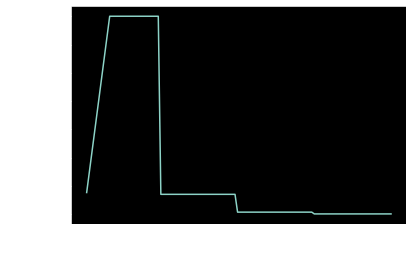

In [22]:
x = []
y = []

optimizer = torch.optim.SGD(net.parameters(), lr=0.00035)
cus_lr_scheduler = WarmupMultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1, warmup_factor=0.01, warmup_iters=10)
for i in range(120):
    cus_lr_scheduler.step()
    for j in range(3):
        x.append(i)
        y.append(optimizer.param_groups[-1]['lr'])
        optimizer.step()

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y)
ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1e'))
ax.set_ylabel('Learning rate')
ax.set_xlabel('Epoch')
plt.show()
# plt.close(fig)

# CosineAnnealingWarmRestarts
---
> Warm Restart 사용시 learning rate가 감소한 이후 급격하게 증가하며 local optima의 발생과 overfitting을 방지할 수 있음


c:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:971: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


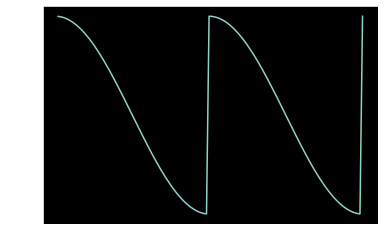

In [6]:
x = []
y = []
cus_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,  T_0=60, T_mult=1, eta_min=0)
for i in range(120):
    cus_lr_scheduler.step()
    for j in range(3):
        x.append(i)
        y.append(cus_lr_scheduler.get_lr()[0])
        optimizer.step()
plt.plot(x, y)
plt.show()

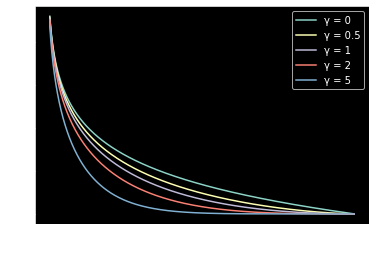

In [11]:
%matplotlib inline
import numpy as np

def method(x, alpha=1, gamma=1):
    return -alpha * np.power(1-x,gamma) *np.log(x+1e-5)

x = np.arange(0.01,1,0.001)
plt.plot(x, method(x,1,0), label='γ = 0')
plt.plot(x, method(x,1,0.5), label='γ = 0.5')
plt.plot(x, method(x,1,1), label='γ = 1')
plt.plot(x, method(x,1,2), label='γ = 2')
plt.plot(x, method(x,1,5), label='γ = 5')

plt.xlabel(f'predicts(q)')
plt.ylabel('focal loss')
plt.legend()

# plt.show()

In [9]:
class CosineLR(object):
    def __init__(self, min_lr, base_lr, max_iters):
        self.min_lr = min_lr
        self.base_lr = base_lr
        self.max_iters = max_iters
    
    def get(self, iter):
        return self.min_lr + 0.5 * (self.base_lr - self.min_lr)*(1 + math.cos(math.pi * iter/self.max_iters))

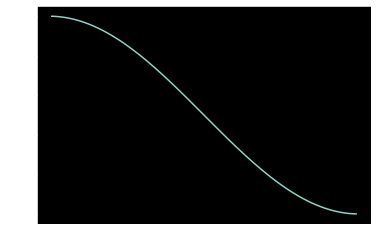

In [10]:
a = np.arange(1, 120, 1)
lr_scheduler = CosineLR(0, 0.1, 120)
b = np.array([lr_scheduler.get(x) for x in a])

plt.plot(a, b)
plt.show()